In [19]:
from os.path import join

import einops
import mne
import torch
from datasets.deap import DEAPDataset
from datasets.eeg_emrec import EEGClassificationDataset

In [10]:
dataset: EEGClassificationDataset = DEAPDataset(
    path=join("..", "..", "..", "datasets", "eeg_emotion_recognition", "deap"),
    split_in_windows=True,
    window_size=1,
    drop_last=True,
    discretize_labels=True,
    normalize_eegs=True,
)

In [11]:
sample = dataset[0]["eegs"]
print(sample.shape)

torch.Size([128, 32])


Opening raw-browser...


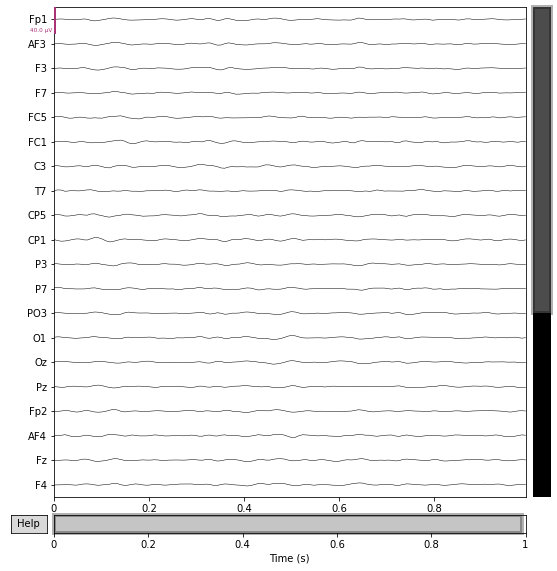

In [23]:
def plot_eeg_sample(sample: torch.Tensor):
    a = mne.io.RawArray(data=einops.rearrange(sample, "s c -> c s"),
                        info=mne.create_info(
                            ch_names=dataset.electrodes,
                            sfreq=dataset.sampling_rate,
                            ch_types="eeg",
                            verbose=False,),
                        verbose=False,
                        )
    a.plot()


plot_eeg_sample(sample)